In [1]:
# pip install spatialmath-python
# pip install roboticstoolbox-python

from spatialmath import *
from roboticstoolbox import *

import numpy as np
import matplotlib.pyplot as plt
import pandas

### Visualizar datos experimentales. Visualice las velocidades angulares para cada experimento (la primera va libre...)

La primera tarea por realizar consiste en visualizar los datos experimentales puros, los mismo se recuperan de los archivos antes indicados, y de ahí en más depende de cómo deseemos trabajarlos en nuestro código. Se presenta un código de ejemplo adjunto en una notebook python que puede servirle para recuperar y visualizar los datos de velocidad angular.

In [2]:
def read_data_from_file(filename):
    df = pandas.read_csv(filename) #recupero datos experimentales
    time=df[["time"]].to_numpy()   #convierto en vector datos recuperados
    a=df[["Acceleration_1","Acceleration_2","Acceleration_3"]].to_numpy()   
    m=df[["MagneticField_1","MagneticField_2","MagneticField_3"]].to_numpy()   
    w=df[["AngularVelocity_1","AngularVelocity_2","AngularVelocity_3"]].to_numpy()   
    orientation=df[["Orientation_1","Orientation_2","Orientation_3"]].to_numpy()   
    return time,a,m,w,orientation

In [3]:
def plot_angular_velocity_from_file(filename):
    time,a,m,w,orientation = read_data_from_file(filename)
    plt.plot(time,w[:,0],label="w1")
    plt.plot(time,w[:,1],label="w2")
    plt.plot(time,w[:,2],label="w3")
    plt.xlabel("time")
    plt.ylabel("w")
    plt.legend()
    plt.show()

EX01: presenta solo giro solo en YAW (alrededor del eje Z) manteniendo el plano horizontal,
inicialmente se mantiene orientación por 20 segundos, luego se gira a -90° manteniendo
por algunos segundos, se vuelve a 0°, luego se gira a 90°, y finalmente se vuelve a la
orientación inicial.

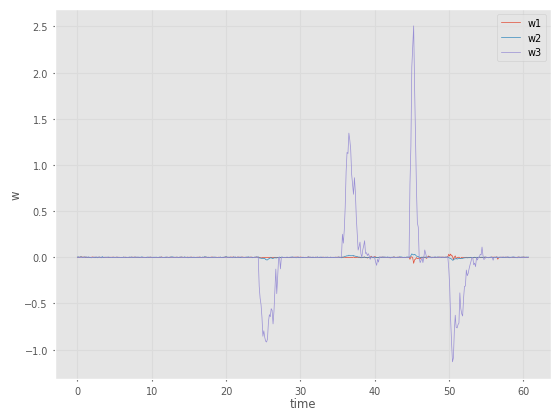

In [4]:
plot_angular_velocity_from_file('EX01.csv')

EX02: presenta solo giro en YAW manteniendo plano horizontal, inicialmente se mantiene
orientación por algunos segundos, luego se gira un poco más de 180°, y luego se vuelve a
orientación original.

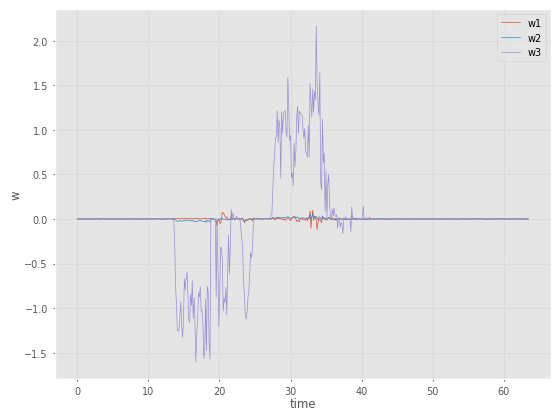

In [5]:
plot_angular_velocity_from_file('EX02.csv')

EX03: presenta giros varios en 3 ejes coordenados, se inicia y termina en la misma
orientación.

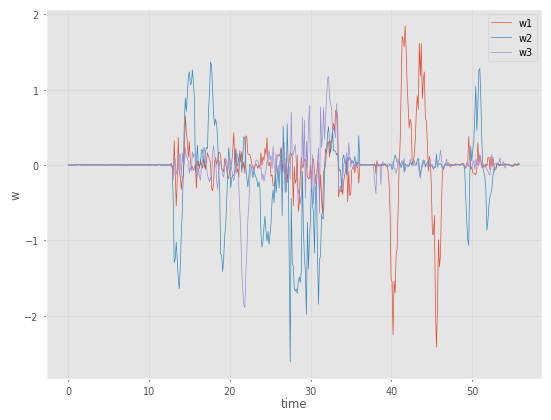

In [6]:
plot_angular_velocity_from_file('EX03.csv')

EX04: presenta posición inicial con eje X alineado a norte magnético (aprox), se mantiene
posición por unos segundos, luego se realizan giros varios en distintos ejes y finalmente se
vuelve a orientación original.

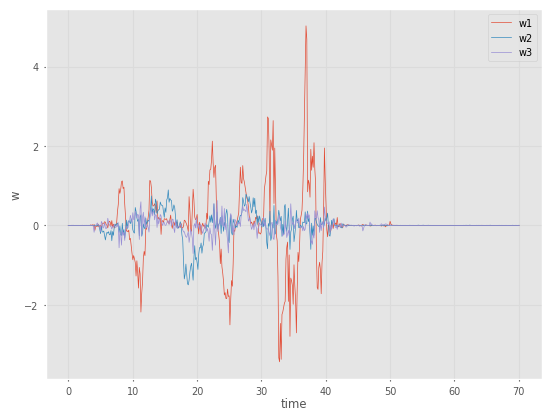

In [7]:
plot_angular_velocity_from_file('EX04.csv')


### A partir de los datos experimentales de velocidad angular estime la orientación del sensor durante el experimento.
Aquí puede comenzar el análisis suponiendo que la orientación inicial es [0,0,0], luego debería
integrar de alguna forma el movimiento registrado por el sensor. Luego debe elegir un elemento
matemático conveniente para representar la pose, ¿cuál utilizaría? -dato vea rotaciones en EX03 Y
EX04. Finalmente, con nuestra selección realizada dos opciones (use la que encuentre más cómoda):

In [8]:
def estimate_orientation_from_file(filename, bias=(0, 0, 0)):
    time, a, m, w, orientation = read_data_from_file(filename)
    current_orientation = SO3()

    r, p, y = [], [], []

    t_prev = None

    w1_bias, w2_bias, w3_bias = bias

    for t, w1, w2, w3 in zip(time, w[:, 0], w[:, 1], w[:, 2]):
        if t_prev is None:
            t_prev = t
            r.append(0)
            p.append(0)
            y.append(0)
            continue
        dt = t - t_prev
        b_R_delta = SO3.Exp(np.array([w1 - w1_bias, w2 - w2_bias, w3 - w3_bias]) * dt)
        current_orientation = current_orientation * b_R_delta
        t_prev = t
        rpy = current_orientation.rpy()
        r.append(rpy[0])
        p.append(rpy[1])
        y.append(rpy[2])

    return time, np.array(r), np.array(p), np.array(y)

In [9]:
def plot_orientation_from_file(t, r, p, y):
    plt.plot(t,r,label="roll")
    plt.plot(t,p,label="pitch")
    plt.plot(t,y,label="yaw")
    plt.xlabel("time")
    plt.ylabel("rpy")
    plt.legend()
    plt.show()

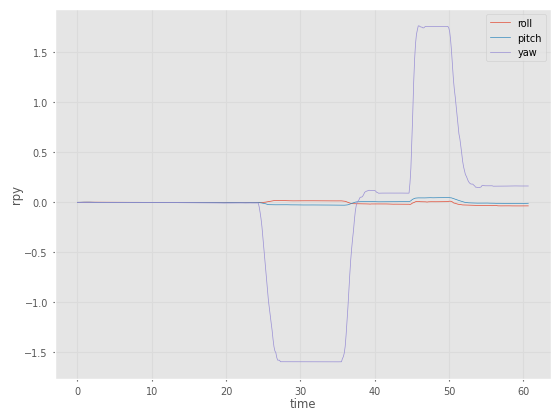

In [10]:
plot_orientation_from_file(*estimate_orientation_from_file('EX01.csv'))

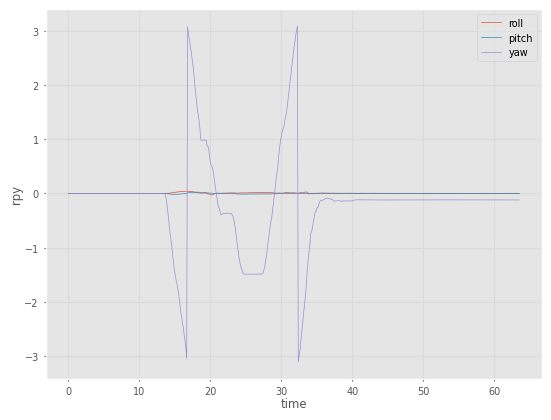

In [11]:
plot_orientation_from_file(*estimate_orientation_from_file('EX02.csv'))

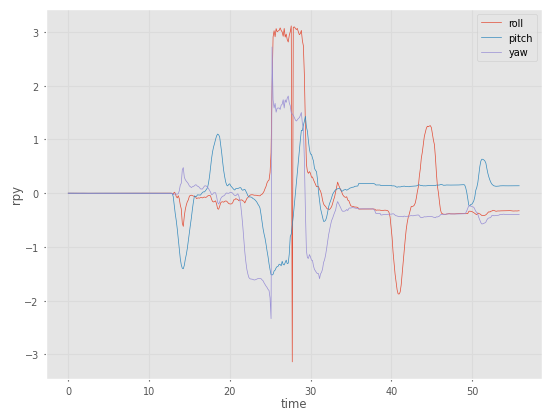

In [12]:
plot_orientation_from_file(*estimate_orientation_from_file('EX03.csv'))

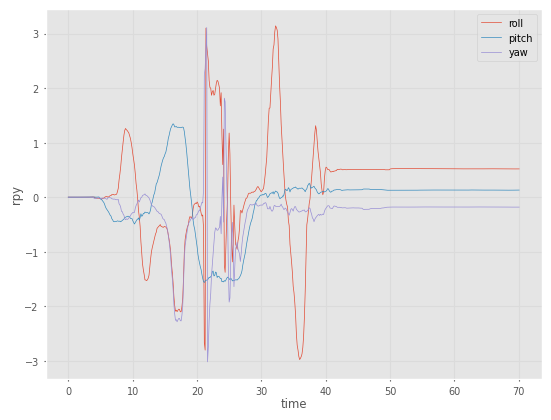

In [13]:
plot_orientation_from_file(*estimate_orientation_from_file('EX04.csv'))

### ¿Podría mejorar la estimación anterior a partir de desafectar el bias de los giróscopos?

Ver que de EX01 tenemos 20 segundos de datos donde el sensor permanece quieto, ¿la salida de los giróscopos es cero?, ¿A qué se deben estos valores?

In [14]:
# read the data from the first file
time1,a1,m1,w1,orientation1 = read_data_from_file('EX01.csv')

# truncate it to the first 20 seconds
w1 = w1[time1[:,0] < 20]

# average the angular velocity over the first 20 seconds
w_biases = np.mean(w1,axis=0)
print(w_biases)

[-9.42693269e-05 -1.41403990e-04 -3.36676167e-04]


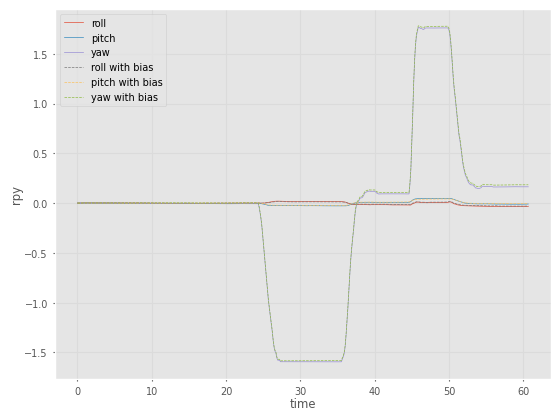

In [15]:
# estimate r, p, y with no bias
t1,r1,p1,y1 = estimate_orientation_from_file('EX01.csv')

# estimate r, p, y with bias
t2,r2,p2,y2 = estimate_orientation_from_file('EX01.csv',bias=w_biases)

# plot the results in the same figure
plt.plot(t1,r1,label="roll")
plt.plot(t1,p1,label="pitch")
plt.plot(t1,y1,label="yaw")
plt.plot(t2,r2,label="roll with bias", linestyle='--')
plt.plot(t2,p2,label="pitch with bias", linestyle='--')
plt.plot(t2,y2,label="yaw with bias", linestyle='--')
plt.xlabel("time")
plt.ylabel("rpy")
plt.legend()
plt.show()

### Suponiendo que no conoce la orientación inicial de cada experimento, estime la orientación inicial de los mismos respecto del norte geográfico y el "plano de tierra".

Para esta tarea deberá buscar elementos de referencia que se encuentren en el marco inercial
(marco mundo) y ver como los mismos se mapean al marco del robot, a partir de esto podrá despejar
los ángulos de rotación del marco del sensor al marco mundo.

In [16]:
gravity = 9.81

def estimate_initial_orientation_in_world(filename, declination):
    time, a, m, w, orientation = read_data_from_file(filename)
    ax, ay, az = a[0]
    mx, my, mz = m[0]
    print(m[0])
    pitch = np.arcsin(-ax / gravity)
    roll = np.arctan2(ay, az)
    B = np.sqrt(mx ** 2 + my ** 2 + mz ** 2) # intensidad de campo magnético
    I = np.arctan2(mx, np.sqrt(mz ** 2 + my ** 2)) # inclinación del campo magnético
    heading_m = np.arctan(
        np.cos(pitch) * (mz * np.sin(roll) - my * np.cos(roll)) /
        (mx + B * np.sin(I) * np.sin(pitch)),
    )
    # correción por declinación
    heading_g = heading_m  - declination
    return roll, pitch, heading_g

In [ ]:
declination_in_la_plata = np.deg2rad(-10.25) # En realidad es 10 grados 14 minutos

print("Orientación estimada")
roll, pitch, heading = estimate_initial_orientation_in_world('EX01.csv', declination_in_la_plata)
print("roll:", np.rad2deg(roll))
print("pitch:", np.rad2deg(pitch))
print("heading:", np.rad2deg(heading))

# No estoy realmente seguro de que estos valores están bien, no entiendo la convención de los datos de orientación en los CSV


Orientación estimada
[ 22.375  -18.      23.0625]
roll: -0.5846305180385237
pitch: -1.0513577478554958
heading: 49.20947570855553
